# Development Notebook for Cortical Crowding Project

In [1]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import neuropythy as ny
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize
from scipy.stats import gmean
from scipy.optimize import curve_fit

/home/lindazelinzhou/.conda/envs/neuro/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# We want to be able to load in libraries that are in this repository's src directory,
# so we add src to the system path:
sys.path.append('../src')

# Now we can import corticalcrowding from the src directory:
import corticalcrowding as cc

In [3]:
df = pd.read_csv('/data/crowding/crowding_data_withID.csv')

In [4]:
sids_NYU = [
    'sub-wlsubj070',
    'sub-wlsubj114',
    'sub-wlsubj121',
    'sub-wlsubj135']
sids_NEI = [ 
    'sub-wlsubj119',
    'sub-wlsubj127',
    'sub-wlsubj136',
    'sub-wlsubj137',
    'sub-wlsubj143',
    'sub-wlsubj144',
    'sub-wlsubj145',
    'sub-wlsubj146',
    'sub-wlsubj147',
    'sub-wlsubj148',
    'sub-wlsubj149',
    'sub-wlsubj150',
    'sub-wlsubj151',
    'sub-wlsubj152',
    'sub-wlsubj153',
    'sub-wlsubj154',
    'sub-wlsubj155',
    'sub-wlsubj156',
    'sub-wlsubj157',
    'sub-wlsubj158',
    'sub-wlsubj159',
    'sub-wlsubj160',
    'sub-wlsubj161',
    'sub-wlsubj162',
    'sub-wlsubj163',
    'sub-wlsubj164',
    'sub-wlsubj165',
    'sub-wlsubj166',
    'sub-wlsubj167',
    'sub-wlsubj168',
    'sub-wlsubj170',
    'sub-wlsubj171',
    'sub-wlsubj172',
    'sub-wlsubj173',
    'sub-wlsubj174',
    'sub-wlsubj175',
    'sub-wlsubj176']

In [5]:
sids_orig = sids_NYU + sids_NEI
sids_orig

['sub-wlsubj070',
 'sub-wlsubj114',
 'sub-wlsubj121',
 'sub-wlsubj135',
 'sub-wlsubj119',
 'sub-wlsubj127',
 'sub-wlsubj136',
 'sub-wlsubj137',
 'sub-wlsubj143',
 'sub-wlsubj144',
 'sub-wlsubj145',
 'sub-wlsubj146',
 'sub-wlsubj147',
 'sub-wlsubj148',
 'sub-wlsubj149',
 'sub-wlsubj150',
 'sub-wlsubj151',
 'sub-wlsubj152',
 'sub-wlsubj153',
 'sub-wlsubj154',
 'sub-wlsubj155',
 'sub-wlsubj156',
 'sub-wlsubj157',
 'sub-wlsubj158',
 'sub-wlsubj159',
 'sub-wlsubj160',
 'sub-wlsubj161',
 'sub-wlsubj162',
 'sub-wlsubj163',
 'sub-wlsubj164',
 'sub-wlsubj165',
 'sub-wlsubj166',
 'sub-wlsubj167',
 'sub-wlsubj168',
 'sub-wlsubj170',
 'sub-wlsubj171',
 'sub-wlsubj172',
 'sub-wlsubj173',
 'sub-wlsubj174',
 'sub-wlsubj175',
 'sub-wlsubj176']

## crowding

In [6]:
mean_cd_polar = df.groupby(['ID','Eccen_X','Eccen_Y'])['CrowdingDistance'].apply(gmean).reset_index()

In [7]:
mean_cd_polar

,ID,Eccen_X,Eccen_Y,CrowdingDistance
0,sub-wlsubj001,-10.0,0.0,3.757971
1,sub-wlsubj001,-5.0,0.0,1.905962
2,sub-wlsubj001,-2.5,0.0,0.777402
3,sub-wlsubj001,0.0,-10.0,4.115811
4,sub-wlsubj001,0.0,-5.0,1.917689
...,...,...,...,...
235,sub-wlsubj158,0.0,5.0,1.284848
236,sub-wlsubj158,0.0,10.0,3.560097
237,sub-wlsubj158,2.5,0.0,0.329442
238,sub-wlsubj158,5.0,0.0,0.828792


In [8]:
# each subject has 1 cd value at each eccentricity
mean_cd = df.groupby(['ID','RadialEccentricity'])['CrowdingDistance'].apply(gmean).reset_index()

In [9]:
cd_list = df['CrowdingDistance'].tolist()
mean_cd_list=mean_cd['CrowdingDistance'].tolist()

In [10]:
# create 3 dfs based on eccen
mean_1 = mean_cd[mean_cd['RadialEccentricity']==2.5]
m_1 = mean_1['CrowdingDistance'].mean()
st_1 = mean_1['CrowdingDistance'].std()
mean_2 = mean_cd[mean_cd['RadialEccentricity']==5]
m_2 = mean_2['CrowdingDistance'].mean()
st_2 = mean_2['CrowdingDistance'].std()
mean_3 = mean_cd[mean_cd['RadialEccentricity']==10]
m_3 = mean_3['CrowdingDistance'].mean()
st_3 = mean_3['CrowdingDistance'].std()

In [11]:
x_ecc = df['RadialEccentricity'].tolist()
mean_x_ecc = mean_cd['RadialEccentricity'].tolist()

In [12]:
b, _ = curve_fit(cc.crowding.func_cd, x_ecc, np.log10(cd_list), p0=0.15)
b

array([0.19811346])

In [13]:
mean_values = [m_1, m_2, m_3]
std_values = [st_1, st_2, st_3]
eccentricities = [2.5, 5, 10]

In [14]:
mean_values

[0.6885809437409106, 1.3966182263508535, 3.422964015001243]

## calculate cortical magnification

In [15]:
eccen = np.linspace(1, 11, 1000)

In [16]:
all_cmag_v1 = []
all_cmag_v2 = []
all_cmag_v3 = []
all_cmag_v4 = []
all_eccen_v1 = []
all_eccen_v2 = []
all_eccen_v3 = []
all_eccen_v4 = []
all_mask = ('variance_explained', 0.04, 1)

for sid in sids_orig:
    try:
        sub = cc.cmag.load_subject(sid)
        print(sid)
        # Calculate cmag for the subject for V1
        v1_mask = {'and': [('visual_area', 1), all_mask]}
        eccen_v1, cmag_v1 = cc.cmag.ring_cmag(sub, eccen=None, mask=v1_mask)
        all_eccen_v1.append(eccen_v1)
        all_cmag_v1.append(cmag_v1)

        # Calculate cmag for the subject for V2
        v2_mask = {'and': [('visual_area', 2), all_mask]}
        eccen_v2, cmag_v2 = cc.cmag.ring_cmag(sub, eccen=None, mask=v2_mask)
        all_eccen_v2.append(eccen_v2)
        all_cmag_v2.append(cmag_v2)

        # Calculate cmag for the subject for V3
        v3_mask = {'and': [('visual_area', 3), all_mask]}
        eccen_v3, cmag_v3 = cc.cmag.ring_cmag(sub, eccen=None, mask=v3_mask)
        all_eccen_v3.append(eccen_v3)
        all_cmag_v3.append(cmag_v3)
        
        # Calculate cmag for the subject for V4
        v4_mask = {'and': [('visual_area', 4), all_mask]}
        eccen_v4, cmag_v4 = cc.cmag.ring_cmag(sub, eccen=None, mask=v4_mask)
        all_eccen_v4.append(eccen_v4)
        all_cmag_v4.append(cmag_v4)
        
    
    except Exception as e:
        print(f"Error calculating cmag for subject {sid}: {e}")

all_flatcmag_v1 = np.concatenate(all_cmag_v1)
all_flateccen_v1 = np.concatenate(all_eccen_v1)
all_flatcmag_v2 = np.concatenate(all_cmag_v2)
all_flateccen_v2 = np.concatenate(all_eccen_v2)
all_flatcmag_v3 = np.concatenate(all_cmag_v3)
all_flateccen_v3 = np.concatenate(all_eccen_v3)
all_flatcmag_v4 = np.concatenate(all_cmag_v4)
all_flateccen_v4 = np.concatenate(all_eccen_v4)

sub-wlsubj070
sub-wlsubj114
sub-wlsubj121
sub-wlsubj135
sub-wlsubj119
sub-wlsubj127
sub-wlsubj136
sub-wlsubj137
sub-wlsubj143
sub-wlsubj144
sub-wlsubj145
sub-wlsubj146
sub-wlsubj147
sub-wlsubj148
sub-wlsubj149
sub-wlsubj150
sub-wlsubj151
sub-wlsubj152
sub-wlsubj153
sub-wlsubj154
sub-wlsubj155
sub-wlsubj156
sub-wlsubj157
sub-wlsubj158
sub-wlsubj159
sub-wlsubj160
Error calculating cmag for subject sub-wlsubj161: Could not interpret source path: /data/NYUNEI/derivatives/prfvista/sub-wlsubj161/ses-nyu3t01/lh.angle_adj.mgz
sub-wlsubj162
sub-wlsubj163
sub-wlsubj164
sub-wlsubj165
sub-wlsubj166
sub-wlsubj167
sub-wlsubj168
sub-wlsubj170
Error calculating cmag for subject sub-wlsubj171: no boundaries found for any raters for subject sub-wlsubj171, hemi rh
sub-wlsubj172
sub-wlsubj173
sub-wlsubj174
sub-wlsubj175
sub-wlsubj176


[18.000770239669478, 1.2428780752012794] [17.05112583592619, 4.042965078525115, 3.4248690497294256]


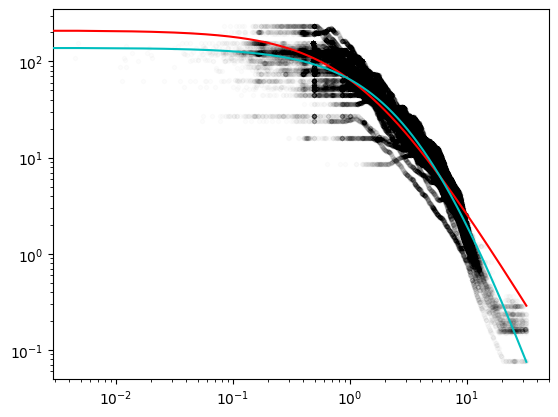

In [17]:
ii = (all_flateccen_v1 < 11) & (all_flatcmag_v1 > 0) & (all_flateccen_v1 > 0.2)
popt1 = cc.cmag.fit_cmag(all_flateccen_v1[ii], all_flatcmag_v1[ii],method='BFGS')
popt1_3params = cc.cmag.fit_cmag(all_flateccen_v1[ii], all_flatcmag_v1[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt1,popt1_3params)
plt.loglog(all_flateccen_v1,all_flatcmag_v1,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v1)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt1),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt1_3params),'c-', zorder=10)
plt.show()

[15.017923908525614, 0.7489871951733137] [13.819859152509112, 1.55503155992758, 2.584289084375119]


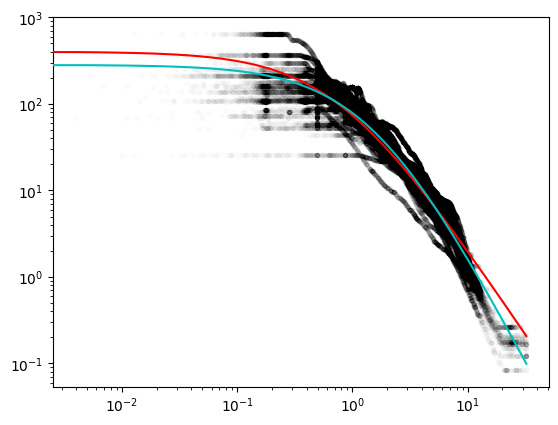

In [18]:
ii = (all_flateccen_v2 < 11) & (all_flatcmag_v2 > 0) & (all_flateccen_v2 > 0.2)
popt2 = cc.cmag.fit_cmag(all_flateccen_v2[ii], all_flatcmag_v2[ii],method='BFGS')
popt2_3params = cc.cmag.fit_cmag(all_flateccen_v2[ii], all_flatcmag_v2[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt2,popt2_3params)
plt.loglog(all_flateccen_v2,all_flatcmag_v2,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v2)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt2),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt2_3params),'c-', zorder=10)
plt.show()

[12.927835969851643, 0.7091803861761306] [11.201567900126696, 1.19116213467417, 2.6425253611919794]


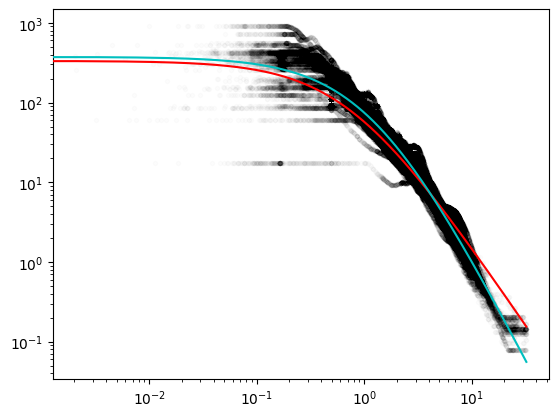

In [19]:
ii = (all_flateccen_v3 < 11) & (all_flatcmag_v3 > 0) & (all_flateccen_v3 > 0.2)
popt3 = cc.cmag.fit_cmag(all_flateccen_v3, all_flatcmag_v3,method='BFGS')
popt3_3params = cc.cmag.fit_cmag(all_flateccen_v3[ii], all_flatcmag_v3[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt3,popt3_3params)
plt.loglog(all_flateccen_v3,all_flatcmag_v3,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v3)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt3),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt3_3params),'c-', zorder=10)
plt.show()

[7.994372118904104, 0.17253953167682087] [7.0823799322495375, 0.47828994495740085, 2.526075777176893]


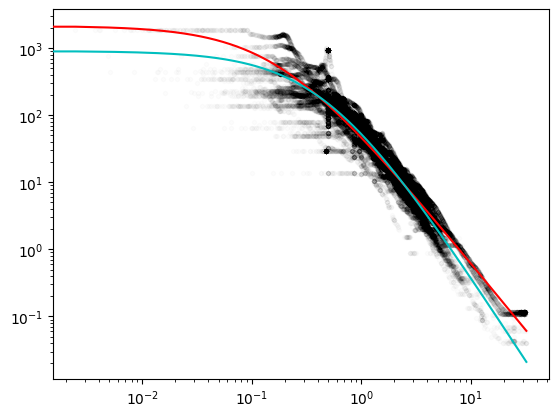

In [20]:
ii = (all_flateccen_v4 < 11) & (all_flatcmag_v4 > 0) & (all_flateccen_v4 > 0.2)
popt4 = cc.cmag.fit_cmag(all_flateccen_v4[ii], all_flatcmag_v4[ii],method='BFGS')
popt4_3params = cc.cmag.fit_cmag(all_flateccen_v4[ii], all_flatcmag_v4[ii],p0=[17.3,0.75,2],method='BFGS')
print(popt4,popt4_3params)
plt.loglog(all_flateccen_v4,all_flatcmag_v4,'k.',alpha=0.01) 
plot_ecc = np.sort(all_flateccen_v4)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt4),'r-', zorder=10)
plt.loglog(plot_ecc, cc.cmag.HH91(plot_ecc, *popt4_3params),'c-', zorder=10)
plt.show()

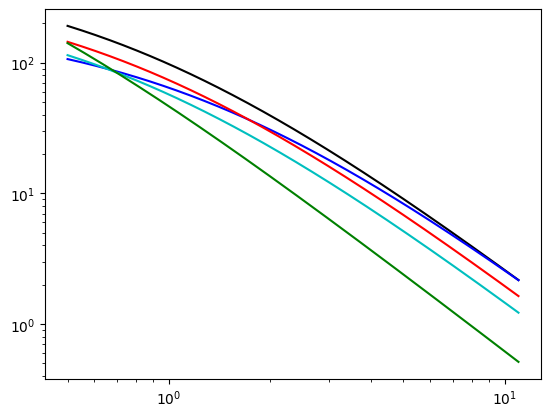

In [21]:
eccen = np.linspace(0.5, 11, 1000)
plt.loglog(eccen, cc.cmag.HH91(eccen),'k-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt1),'b-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt2),'r-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt3),'c-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt4),'g-')
plt.show()

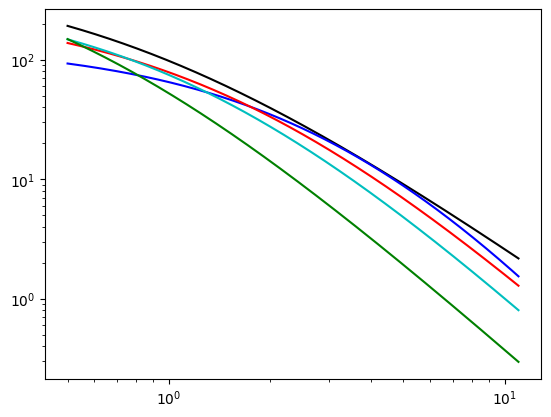

In [22]:
eccen = np.linspace(0.5, 11, 1000)
plt.loglog(eccen, cc.cmag.HH91(eccen),'k-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt1_3params),'b-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt2_3params),'r-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt3_3params),'c-')
plt.loglog(eccen, cc.cmag.HH91(eccen, *popt4_3params),'g-')
plt.show()

## add cortical magnification values to df

In [23]:
# magnification_values is a dict containing cmag for each visual area
magnification_values = cc.cmag.calculate_cortical_magnification(df)

for mask_value in [1, 2, 3, 4]:
    col_name = f'CorticalMagnification_{mask_value}'
    df.loc[:, col_name] = magnification_values[mask_value]

In [24]:
df_sub_polar = df.groupby(['Eccen_X','Eccen_Y','ID'])[[
    'CorticalMagnification_1',
    'CorticalMagnification_2',
    'CorticalMagnification_3',
    'CorticalMagnification_4'
]].mean().reset_index()

In [25]:
df_cell = df_sub_polar
# convert 2d cortical magnification into 1d visual magnification and change the names of columns accordingly
for col in ['CorticalMagnification_1', 'CorticalMagnification_2', 'CorticalMagnification_3', 'CorticalMagnification_4']:
    df_cell[col] = np.sqrt(1 / df_cell[col])
df_cell.rename(columns={
    'CorticalMagnification_1': 'VisualMagnification_1',
    'CorticalMagnification_2': 'VisualMagnification_2',
    'CorticalMagnification_3': 'VisualMagnification_3',
    'CorticalMagnification_4': 'VisualMagnification_4'
}, inplace=True)

In [26]:
# sort the df
df_cell.sort_values(by=['ID', 'Eccen_X','Eccen_Y'], inplace=True)
# add the crowding values to the df
mean_for_sub = mean_cd_polar['CrowdingDistance'].values
df_cell['CrowdingDistance'] = mean_for_sub

In [27]:
# drop nan values
df_sub_clean = df_cell.dropna(subset=['VisualMagnification_1'])

In [51]:
mean_cd_polar[mean_cd_polar['ID']=='sub-wlsubj135']

,ID,Eccen_X,Eccen_Y,CrowdingDistance
120,sub-wlsubj135,-10.0,0.0,5.235605
121,sub-wlsubj135,-5.0,0.0,1.464074
122,sub-wlsubj135,-2.5,0.0,0.843480
123,sub-wlsubj135,0.0,-10.0,3.734183
124,sub-wlsubj135,0.0,-5.0,1.953545
125,sub-wlsubj135,0.0,-2.5,0.919151
126,sub-wlsubj135,0.0,2.5,0.869326
127,sub-wlsubj135,0.0,5.0,1.815791
128,sub-wlsubj135,0.0,10.0,5.081154
129,sub-wlsubj135,2.5,0.0,0.783623


In [50]:
df_sub_clean[df_sub_clean['ID']=='sub-wlsubj135']

,Eccen_X,Eccen_Y,ID,VisualMagnification_1,VisualMagnification_2,VisualMagnification_3,VisualMagnification_4,CrowdingDistance
10,-10.0,0.0,sub-wlsubj135,0.596805,0.744094,0.897366,1.150861,5.235605
30,-5.0,0.0,sub-wlsubj135,0.220732,0.351249,0.437869,0.467495,1.464074
50,-2.5,0.0,sub-wlsubj135,0.144201,0.150323,0.197651,0.282299,0.843480
70,0.0,-10.0,sub-wlsubj135,0.698656,0.689309,0.928124,1.627423,3.734183
90,0.0,-5.0,sub-wlsubj135,0.304629,0.299625,0.422864,0.853728,1.953545
110,0.0,-2.5,sub-wlsubj135,0.166486,0.140870,0.193448,0.515833,0.919151
130,0.0,2.5,sub-wlsubj135,0.188756,0.186347,0.276275,0.383052,0.869326
150,0.0,5.0,sub-wlsubj135,0.341228,0.394164,0.537177,0.651130,1.815791
170,0.0,10.0,sub-wlsubj135,0.683360,0.776948,1.001145,1.352788,5.081154
190,2.5,0.0,sub-wlsubj135,0.199882,0.220880,0.204339,0.292812,0.783623


## plot visual magnification and crowding values 

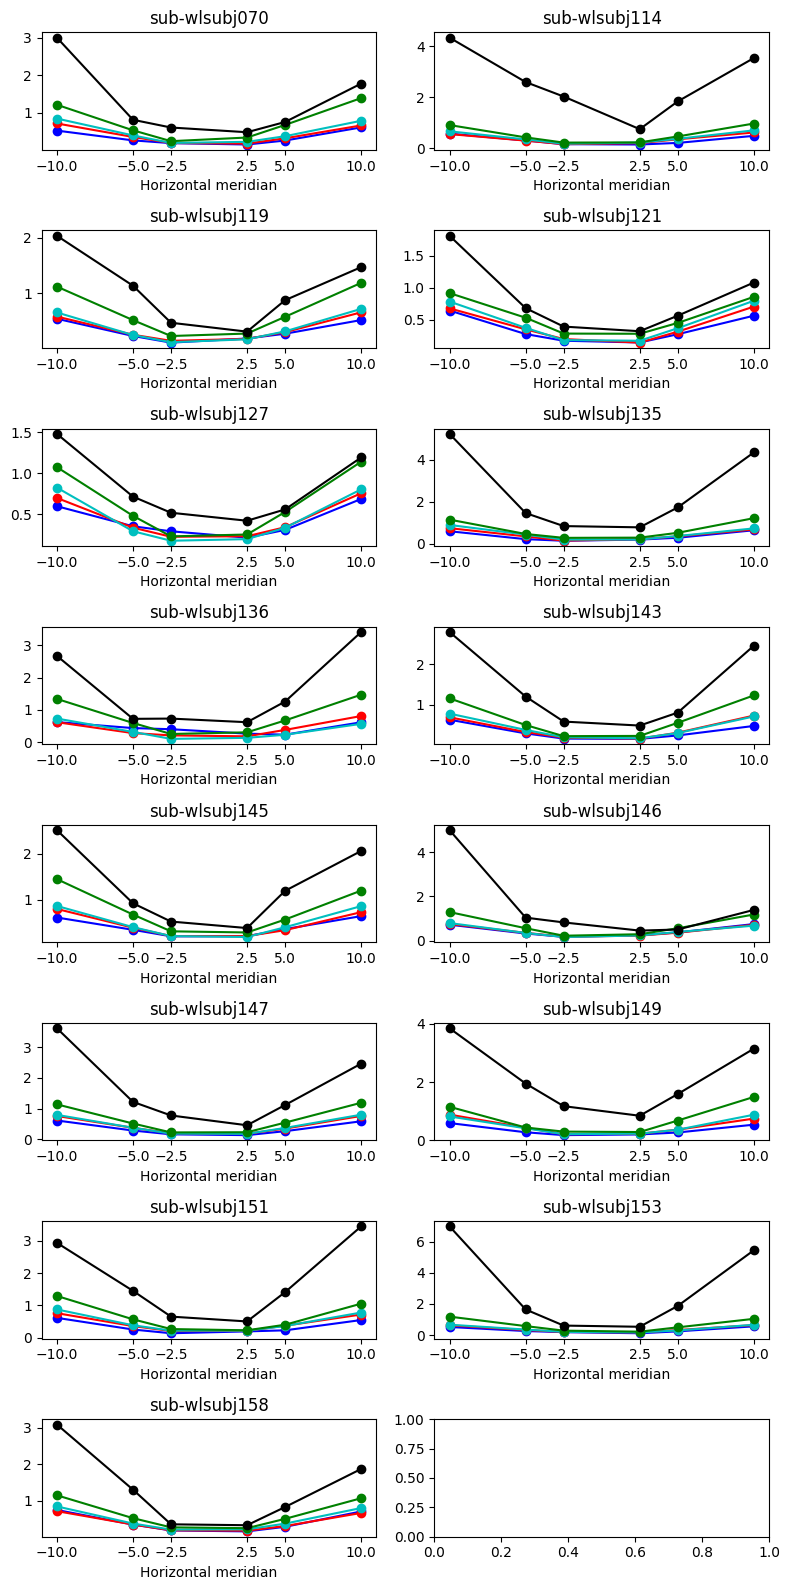

In [28]:
sids = np.unique(df_sub_clean['ID'])
fig, axes = plt.subplots((len(sids)+1)//2,2, figsize=(8,16))
x_ticks = [-10, -5, -2.5, 2.5, 5, 10]
for sid, ax in zip(sids, axes.flat):
    subject_data = df_sub_clean[(df_sub_clean['ID']==sid) & (df_sub_clean['Eccen_Y']==0)]
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values
    
    ax.plot(subject_data['Eccen_X'], y1, 'bo-')
    ax.plot(subject_data['Eccen_X'], y2, 'ro-')
    ax.plot(subject_data['Eccen_X'], y3, 'co-')
    ax.plot(subject_data['Eccen_X'], y4, 'go-')
    ax.plot(subject_data['Eccen_X'], y5, 'ko-')
    
    ax.set_xticks(x_ticks)
    ax.set_title(sid)
    ax.set_xlabel("Horizontal meridian")
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

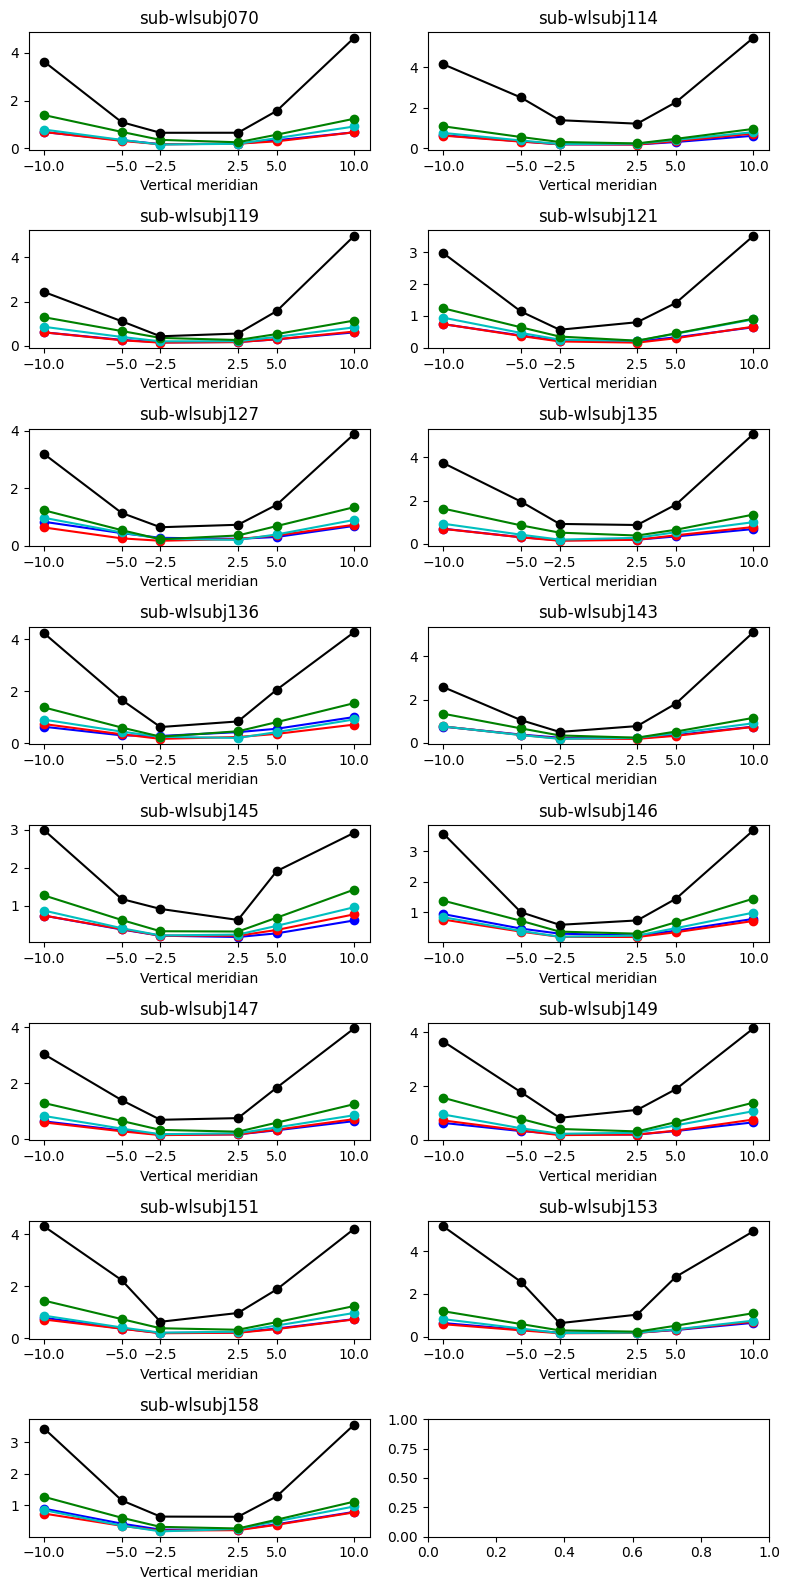

In [29]:
fig, axes = plt.subplots((len(sids)+1)//2,2, figsize=(8,16))
x_ticks = [-10, -5, -2.5, 2.5, 5, 10]

for sid, ax in zip(sids, axes.flat):
    subject_data = df_sub_clean[(df_sub_clean['ID']==sid) & (df_sub_clean['Eccen_X']==0)]
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values
    
    ax.plot(subject_data['Eccen_Y'], y1, 'bo-')
    ax.plot(subject_data['Eccen_Y'], y2, 'ro-')
    ax.plot(subject_data['Eccen_Y'], y3, 'co-')
    ax.plot(subject_data['Eccen_Y'], y4, 'go-')
    ax.plot(subject_data['Eccen_Y'], y5, 'ko-')
    
    ax.set_xticks(x_ticks)
    ax.set_title(sid)
    ax.set_xlabel("Vertical meridian")
    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## use cortical magnification to predict crowding

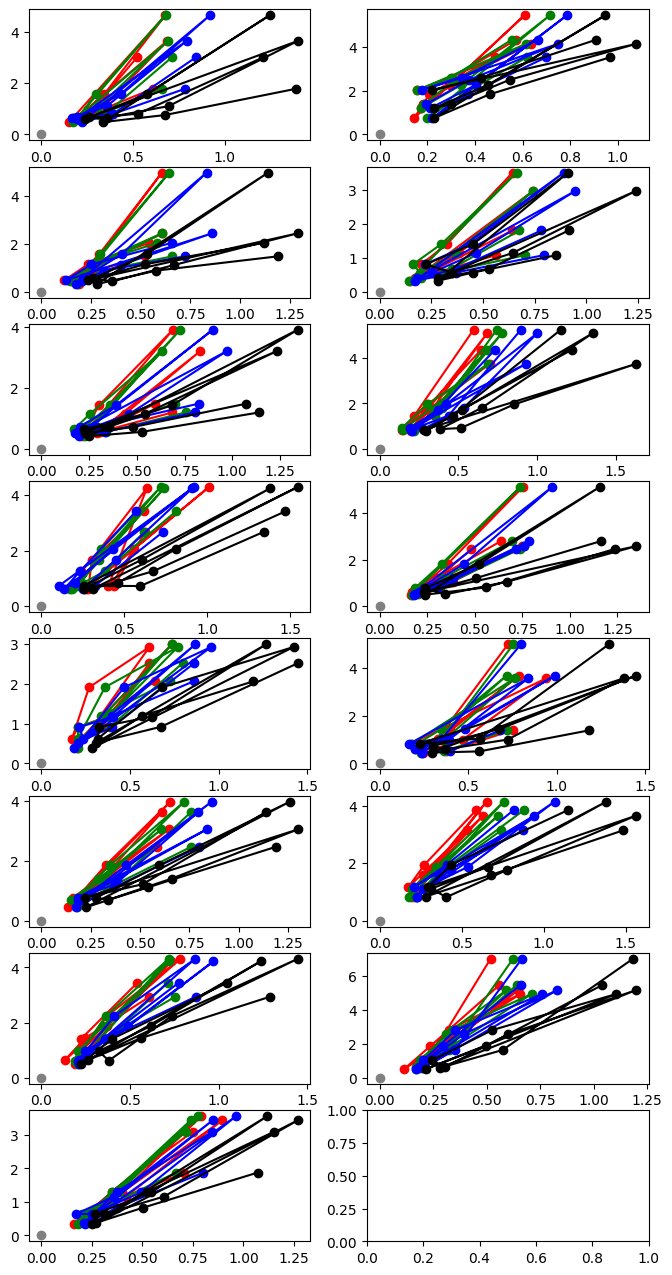

In [30]:
sids = np.unique(df_sub_clean['ID'])

fig, axes = plt.subplots((len(sids)+1)//2,2, figsize=(8,16))

for sid, ax in zip(sids, axes.flat):
    subject_data = df_sub_clean[df_sub_clean['ID']==sid]
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values

    rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
    rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
    rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
    rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)

    ax.plot(y1, y5, 'ro-')
    ax.plot(y2, y5, 'go-')
    ax.plot(y3, y5, 'bo-')
    ax.plot(y4, y5, 'ko-')
    ax.scatter([0],[0],color = '0.5')
#ax.axis('equal')

In [31]:
grouped = df_sub_clean.groupby('ID')
subject_results = {}

# Iterate over each subject to do the regression
for subject, subject_data in grouped:
    y1 = subject_data['VisualMagnification_1'].values
    y2 = subject_data['VisualMagnification_2'].values
    y3 = subject_data['VisualMagnification_3'].values
    y4 = subject_data['VisualMagnification_4'].values
    y5 = subject_data['CrowdingDistance'].values

    
    rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
    rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
    rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
    rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)
    
    rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
    best_fit_index = np.argmin(rss_values)
    best_fit = ['y1','y2','y3','y4'][best_fit_index]
    
    # create a dict to store values
    subject_results[subject] = {
        'rss_y1': rss_y1, 'coef_y1': coef_y1,
        'rss_y2': rss_y2, 'coef_y2': coef_y2,
        'rss_y3': rss_y3, 'coef_y3': coef_y3,
        'rss_y4': rss_y4, 'coef_y4': coef_y4,
        'best_fit': best_fit
    }

for subject, results in subject_results.items():
    print(f"Results for {subject}:")
    print(f"RSS for y1: {results['rss_y1']}, Coefficient: {results['coef_y1']}")
    print(f"RSS for y2: {results['rss_y2']}, Coefficient: {results['coef_y2']}")
    print(f"RSS for y3: {results['rss_y3']}, Coefficient: {results['coef_y3']}")
    print(f"RSS for y4: {results['rss_y4']}, Coefficient: {results['coef_y4']}")
    print(f"The best fit is: {results['best_fit']}\n")


Results for sub-wlsubj070:
RSS for y1: 4.5991250620100415, Coefficient: 4.851692665805341
RSS for y2: 5.700066129714277, Coefficient: 4.427708628958376
RSS for y3: 4.29214970683936, Coefficient: 3.7110547904064224
RSS for y4: 6.607314203949757, Coefficient: 2.301082067659876
The best fit is: y3

Results for sub-wlsubj114:
RSS for y1: 2.1368928788858916, Coefficient: 7.715719873204415
RSS for y2: 3.0531242166542114, Coefficient: 7.010608317603505
RSS for y3: 3.052697888704224, Coefficient: 6.0884017984990075
RSS for y4: 4.396898253589891, Coefficient: 4.572098546111714
The best fit is: y1

Results for sub-wlsubj119:
RSS for y1: 6.609358871037849, Coefficient: 4.660787130891591
RSS for y2: 7.523718942983741, Coefficient: 4.273366198864452
RSS for y3: 6.160997139752036, Coefficient: 3.526578692643314
RSS for y4: 8.358365491579725, Coefficient: 2.1931975419852816
The best fit is: y3

Results for sub-wlsubj121:
RSS for y1: 3.2080443005915593, Coefficient: 3.5174714404303526
RSS for y2: 4.56

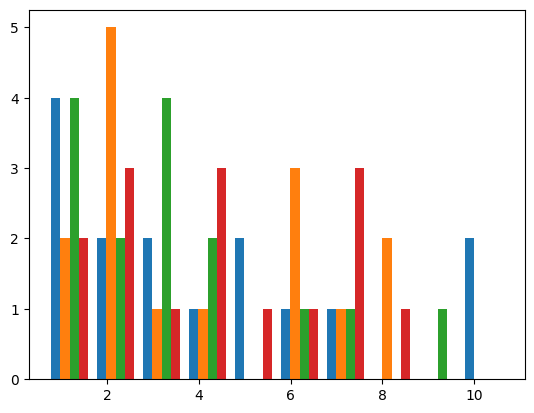

In [32]:
key = 'rss_y1'
data = [[subdata[key] for subdata in subject_results.values()]
        for key in ['rss_y1','rss_y2','rss_y3','rss_y4']]
plt.hist(data)
plt.show()

In [33]:
rss_y1_values = []
rss_y2_values = []
rss_y3_values = []
rss_y4_values = []

for subject, values in subject_results.items():
    rss_y1_values.append(values['rss_y1'])
    rss_y2_values.append(values['rss_y2'])
    rss_y3_values.append(values['rss_y3'])
    rss_y4_values.append(values['rss_y4'])

mean_rss_y1 = np.mean(rss_y1_values)
mean_rss_y2 = np.mean(rss_y2_values)
mean_rss_y3 = np.mean(rss_y3_values)
mean_rss_y4 = np.mean(rss_y4_values)

std_rss_y1 = np.std(rss_y1_values)
std_rss_y2 = np.std(rss_y2_values)
std_rss_y3 = np.std(rss_y3_values)
std_rss_y4 = np.std(rss_y4_values)

# Print results
print(f"Mean RSS for y1: {mean_rss_y1}, Standard Deviation: {std_rss_y1}")
print(f"Mean RSS for y2: {mean_rss_y2}, Standard Deviation: {std_rss_y2}")
print(f"Mean RSS for y3: {mean_rss_y3}, Standard Deviation: {std_rss_y3}")
print(f"Mean RSS for y4: {mean_rss_y4}, Standard Deviation: {std_rss_y4}")

Mean RSS for y1: 4.2675146588325825, Standard Deviation: 3.0316506021270144
Mean RSS for y2: 4.260626223556132, Standard Deviation: 2.568345942258686
Mean RSS for y3: 3.5136989419827227, Standard Deviation: 2.3333935340296295
Mean RSS for y4: 4.367455131741344, Standard Deviation: 2.3605784353739345


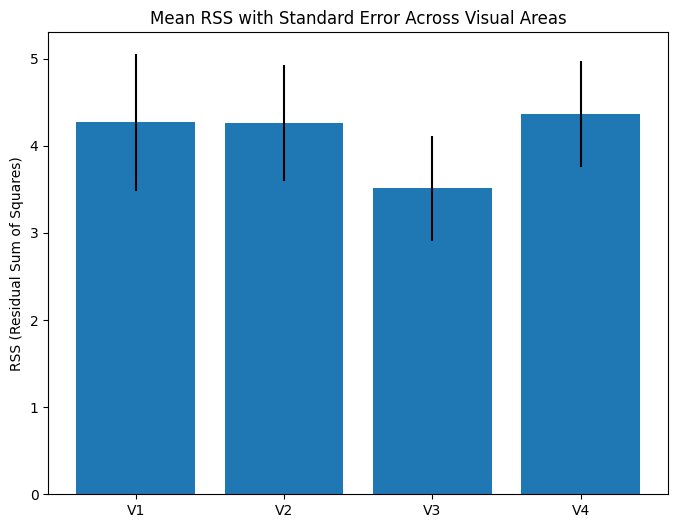

In [34]:
mean_rss = [mean_rss_y1, mean_rss_y2, mean_rss_y3, mean_rss_y4]
std_rss = [std_rss_y1, std_rss_y2, std_rss_y3, std_rss_y4]

labels = ['V1', 'V2', 'V3', 'V4']

plt.figure(figsize=(8, 6))
plt.bar(labels, mean_rss, yerr=std_rss/np.sqrt(len(sids)))

plt.ylabel('RSS (Residual Sum of Squares)')
plt.title('Mean RSS with Standard Error Across Visual Areas')
plt.show()

In [42]:
## look at group data

In [59]:
grouped_df = df.groupby('RadialEccentricity')[[
    'CorticalMagnification_1',
    'CorticalMagnification_2',
    'CorticalMagnification_3',
    'CorticalMagnification_4'
]].mean().reset_index()

# make it 1d visual magnification
for col in ['CorticalMagnification_1', 'CorticalMagnification_2', 'CorticalMagnification_3', 'CorticalMagnification_4']:
    grouped_df[col] = np.sqrt(1 / grouped_df[col])

In [60]:
grouped_df['CrowdingDistance'] = mean_values
grouped_df.rename(columns={
    'CorticalMagnification_1': 'VisualMagnification_1',
    'CorticalMagnification_2': 'VisualMagnification_2',
    'CorticalMagnification_3': 'VisualMagnification_3',
    'CorticalMagnification_4': 'VisualMagnification_4'
}, inplace=True)
grouped_df

,RadialEccentricity,VisualMagnification_1,VisualMagnification_2,VisualMagnification_3,VisualMagnification_4,CrowdingDistance
0,2.5,0.183892,0.184953,0.193874,0.275491,0.688581
1,5.0,0.302033,0.332574,0.376876,0.561310,1.396618
2,10.0,0.637192,0.697668,0.811294,1.194513,3.422964


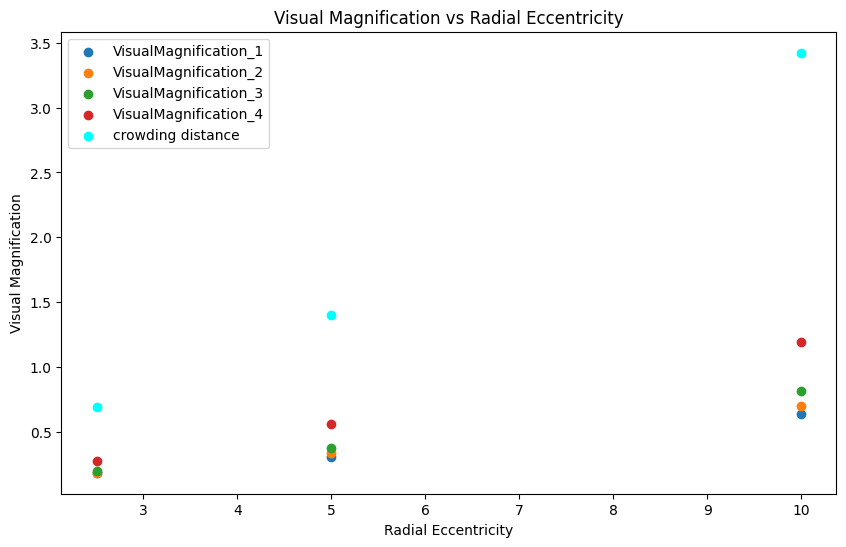

In [61]:
plt.figure(figsize=(10, 6))
for col in ['VisualMagnification_1', 'VisualMagnification_2', 'VisualMagnification_3', 'VisualMagnification_4']:
    plt.scatter(grouped_df['RadialEccentricity'], grouped_df[col], marker='o', linestyle='-', label=col)
plt.scatter(eccentricities, mean_values, color='cyan', label = 'crowding distance')
plt.xlabel('Radial Eccentricity')
plt.ylabel('Visual Magnification')
plt.title('Visual Magnification vs Radial Eccentricity')
plt.legend()
plt.show()

In [62]:
y1 = grouped_df['VisualMagnification_1'].values
y2 = grouped_df['VisualMagnification_2'].values
y3 = grouped_df['VisualMagnification_3'].values
y4 = grouped_df['VisualMagnification_4'].values
y5 = grouped_df['CrowdingDistance'].values

rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)

rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
best_fit_index = np.argmin(rss_values)
best_fit = ['y1', 'y2', 'y3', 'y4'][best_fit_index]

print(f"RSS for y1: {rss_y1}, Coefficient: {coef_y1}")
print(f"RSS for y2: {rss_y2}, Coefficient: {coef_y2}")
print(f"RSS for y3: {rss_y3}, Coefficient: {coef_y3}")
print(f"RSS for y4: {rss_y4}, Coefficient: {coef_y4}")
print(f"The best fit is: {best_fit}")

RSS for y1: 0.1119817090375359, Coefficient: 5.139843889771269
RSS for y2: 0.08086731809430052, Coefficient: 4.718407881955695
RSS for y3: 0.04271283844577696, Coefficient: 4.102166682629508
RSS for y4: 0.043216990732015625, Coefficient: 2.784870873068017
The best fit is: y3


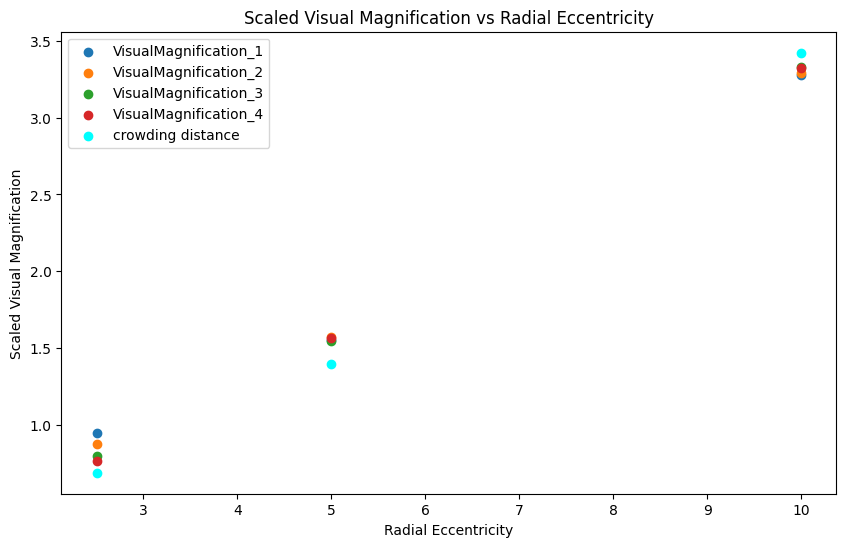

In [63]:
plt.figure(figsize=(10, 6))
for scale, col in zip([coef_y1,coef_y2,coef_y3,coef_y4],['VisualMagnification_1', 'VisualMagnification_2', 'VisualMagnification_3', 'VisualMagnification_4']):
    plt.scatter(grouped_df['RadialEccentricity'], scale * grouped_df[col], marker='o', linestyle='-', label=col)
plt.scatter(eccentricities, mean_values, color='cyan', label = 'crowding distance')
plt.xlabel('Radial Eccentricity')
plt.ylabel('Scaled Visual Magnification')
plt.title('Scaled Visual Magnification vs Radial Eccentricity')
plt.legend()
plt.show()

## Testing alternative fitting

In [39]:
def HH91_vmag(ecc, a=17.3, b=0.75, c=2):
    return ((np.asarray(ecc) + b) / a)**c

def fit_vmag(ecc, cmag, params0=(17.3, 0.75), method=None):
    from scipy.optimize import minimize
    ecc = np.asarray(ecc, dtype=np.float64)
    cmag = np.asarray(cmag, dtype=np.float64)
    vmag = 1/cmag
    def loss_vmag(params):
        params = list(params)
        params[1] = params[1]**2
        pred = HH91_vmag(ecc, *params)
        error = (pred - vmag)
        return np.sum(error**2)
    params0 = list(params0)
    params0[1] = np.sqrt(params0[1])
    r = minimize(loss_vmag, params0, method=method)
    r.x[1] = r.x[1]**2
    r.coords = np.array([ecc,cmag])
    return r

def trimsame(x, *args):
    x = np.asarray(x)
    idx0 = np.where(x != x[0])[0][0] - 1
    idxn = np.where(~np.isclose(x, x[-1]))[0][-1] + 1
    return (x[idx0:idxn],) + tuple(arg[idx0:idxn] for arg in args)

def fit_subject_vmag(sid,
                     params0=(17.3, 0.75),
                     method=None,
                     allmask={'and': [('variance_explained', 0.04, 1),
                                      ('eccentricity', 0, 12)]}):
    sub = cc.cmag.load_subject(sid)
    cmags = []
    eccens = []
    results = []
    for k in range(1,5):
        mask = {'and': [('visual_area', k), allmask]}
        eccen, cmag = cc.cmag.ring_cmag(sub, mask=mask)
        (cmag, eccen) = trimsame(cmag, eccen)
        eccens.append(eccen)
        cmags.append(cmag)
        results.append(fit_vmag(eccen, cmag, params0, method=method))
    return results

In [40]:
rs = fit_subject_vmag('sub-wlsubj150')

(0.5, 512)

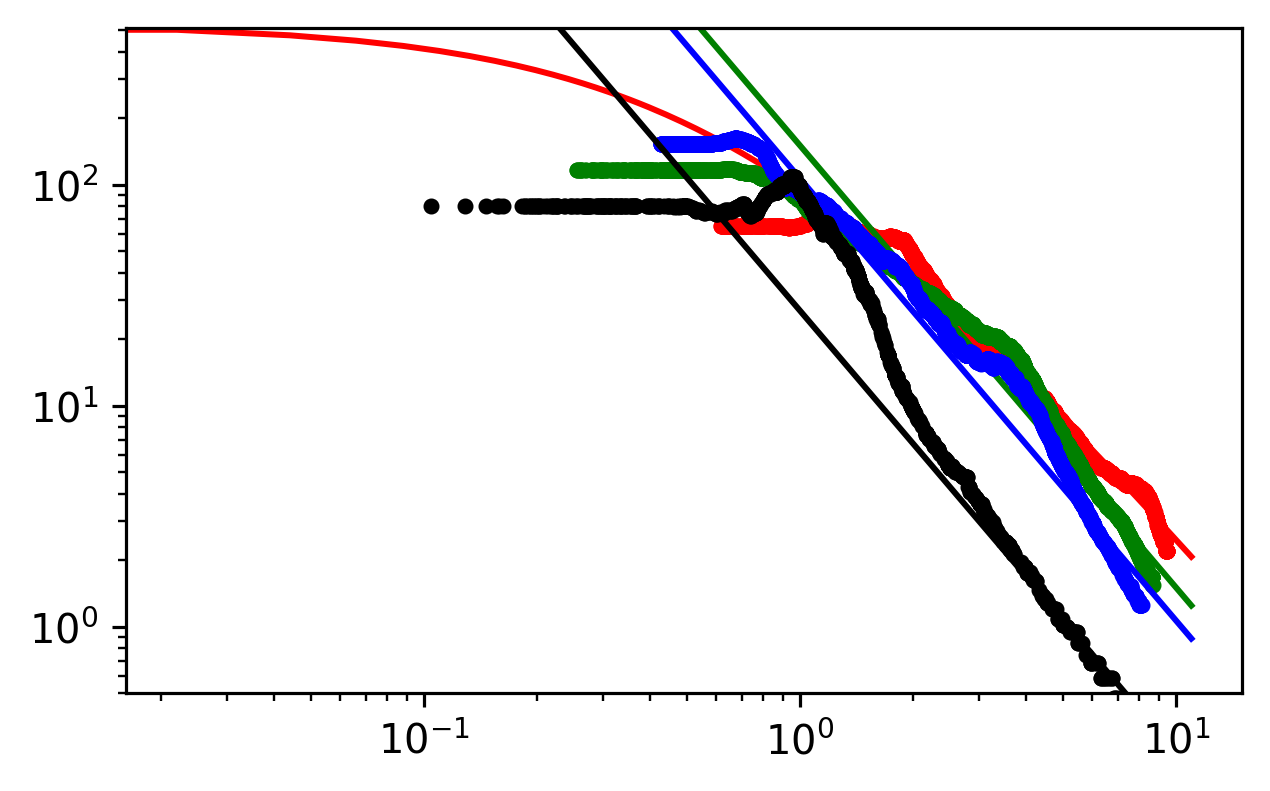

In [41]:
(fig,ax) = plt.subplots(1,1, figsize=(5,3), dpi=288)

eccrng = np.linspace(0, 11, 500)
for (clr,r) in zip(['r','g','b','k'], rs):
    #if clr != 'r': continue
    (ecc,cmag) = r.coords
    if len(r.x) == 3:
        (a,b,c) = r.x
    else:
        (a,b) = r.x
        c = 2
    ax.loglog(ecc, cmag, clr + '.')
    ax.loglog(eccrng, 1/HH91_vmag(eccrng, a, b, c), clr + '-')
ax.set_ylim([0.5,512])

In [42]:
def cmag_basics(sid, h, label):
    sub = cc.cmag.load_subject(sid)
    hem = sub.hemis[h]
    mask_nor2 = {
        'and': [
            ('eccentricity', 0, 12),
            ('visual_area', label)]}
    mask_r2 = {'and': mask_nor2['and'] + [('variance_explained', 0.04, 1)]}
    rdat = ny.retinotopy_data(hem)
    mask_ii = hem.mask(mask_r2)
    ecc = rdat['eccentricity'][mask_ii]
    srf = hem.prop('midgray_surface_area')
    totarea = np.sum(srf[hem.mask(mask_nor2)])
    srf = srf[mask_ii]
    ii = np.argsort(ecc)
    ecc = ecc[ii]
    srf = srf[ii] * totarea / np.sum(srf)
    return (ecc, srf)

$$ c_1 = \sqrt{\frac{a_M}{\pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right)}} $$

In [43]:
def HH91_integral(x, a=17.3, b=0.75):
    xb = x + b
    return a**2 * np.pi * (np.log(xb / b) - x / xb)

def HH91_c1(totalarea, maxecc, b=0.75):
    mb = maxecc + b
    c1 = np.sqrt(totalarea / np.pi / (np.log(mb / b) - maxecc/mb))
    
def fit_cumarea_data(ecc, srf, params0=(17.3, 0.75), method=None):
    from scipy.optimize import minimize
    ecc = np.asarray(ecc, dtype=np.float64)
    srf = np.asarray(srf, dtype=np.float64)
    ii = np.argsort(ecc)
    ecc = ecc[ii]
    srf = srf[ii]
    cumsrf = np.cumsum(srf)
    def loss_vmag(params):
        params = list(params)
        params[1] = params[1]**2
        pred = HH91_integral(ecc, *params)
        error = (pred - cumsrf)
        return np.mean(error**2)
    params0 = list(params0)
    params0[1] = np.sqrt(params0[1])
    r = minimize(loss_vmag, params0, method=method)
    r.x[0] = abs(r.x[0])
    r.x[1] = r.x[1]**2
    r.coords = np.array([ecc,srf])
    return r

def fit_cumarea(sid, h, label):
    (ecc,srf) = cmag_basics(sid, h, label)
    if len(ecc) == 0:
        raise RuntimeError(f"no data found for {sid}:{h}:{label}")
    r = fit_cumarea_data(ecc, srf)
    r.coords = np.array([ecc, srf])
    return r

sub-wlsubj136 lh V4: a= 8.76, b=0.409
sub-wlsubj136 rh V4: a=52.80, b=7.805


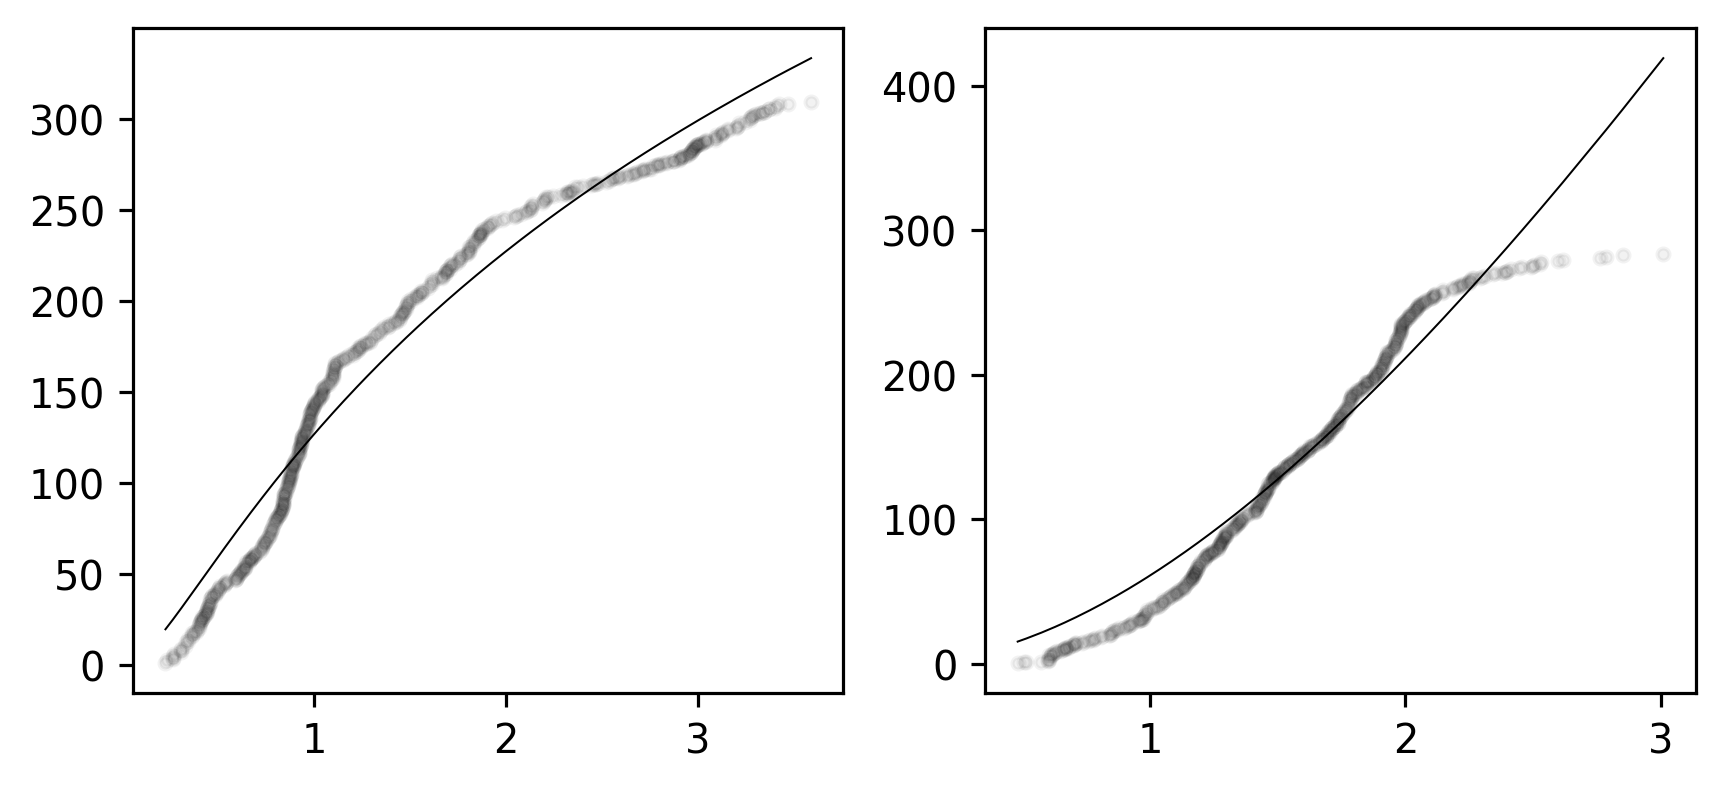

In [95]:
sid = 'sub-wlsubj136'

(fig,axs) = plt.subplots(1,2, figsize=(7,3), dpi=288)
eccrng = np.linspace(0, 11, 500)

for (h,ax) in zip(['lh','rh'], axs):
    for (clr, lbl) in zip(['r','g','b','k'], [1,2,3,4]):
        if lbl != 4:
            continue
        r = fit_cumarea(sid, h, lbl)
        (ecc,srf) = r.coords
        (a,b) = r.x
        print(f"{sid:<13s} {h:2s} V{lbl}: a={a:5.2f}, b={b:5.3f}")
        ax.plot(ecc, np.cumsum(srf), clr + '.', lw=0.5, alpha=0.05)
        ax.plot(ecc, HH91_integral(ecc, a, b), clr + '-', lw=0.5)

In [46]:
df = dict(sid=[], h=[], label=[], a=[], b=[], loss=[])
for sid in sids_orig:
    print(sid)
    for h in ['lh','rh']:
        for lbl in [1,2,3,4]:
            try:
                r = fit_cumarea(sid, h, lbl)
            except Exception as e:
                print(f"  - Skipping: {type(e)}")
                continue
            df['sid'].append(sid)
            df['h'].append(h)
            df['label'].append(lbl)
            df['a'].append(r.x[0])
            df['b'].append(r.x[1])
            df['loss'].append(r.fun)
HH91_params = pd.DataFrame(df)

sub-wlsubj070
sub-wlsubj114
sub-wlsubj121
sub-wlsubj135
sub-wlsubj119
sub-wlsubj127
sub-wlsubj136
sub-wlsubj137
sub-wlsubj143
sub-wlsubj144
sub-wlsubj145
sub-wlsubj146
sub-wlsubj147
sub-wlsubj148
sub-wlsubj149
sub-wlsubj150
sub-wlsubj151
sub-wlsubj152
sub-wlsubj153
sub-wlsubj154
sub-wlsubj155
sub-wlsubj156
sub-wlsubj157
sub-wlsubj158
sub-wlsubj159
sub-wlsubj160
sub-wlsubj161
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
sub-wlsubj162
sub-wlsubj163
sub-wlsubj164
sub-wlsubj165
sub-wlsubj166
sub-wlsubj167
sub-wlsubj168
sub-wlsubj170
  - Skipping: <class 'RuntimeError'>
  - Skipping: <class 'RuntimeError'>
  - Skipping: <class 'RuntimeError'>
  - Skipping: <class 'RuntimeError'>
sub-wlsubj171
  - Skipping: <class 'RuntimeError'>
  - Skipping: <class 'RuntimeEr

In [87]:
HH91_params

,sid,h,label,a,b,loss
0,sub-wlsubj070,lh,1,20.163431,1.104256,1457.656711
1,sub-wlsubj070,lh,2,19.571239,1.482536,1274.891919
2,sub-wlsubj070,lh,3,13.142572,0.400323,1438.388592
3,sub-wlsubj070,lh,4,5.308751,0.130595,750.509142
4,sub-wlsubj070,rh,1,20.421238,1.793989,690.280716
...,...,...,...,...,...,...
303,sub-wlsubj176,lh,4,8.219965,0.182336,227.225729
304,sub-wlsubj176,rh,1,17.623820,0.990181,1689.881910
305,sub-wlsubj176,rh,2,13.476881,0.578077,1128.904503
306,sub-wlsubj176,rh,3,10.399002,0.398794,240.181767


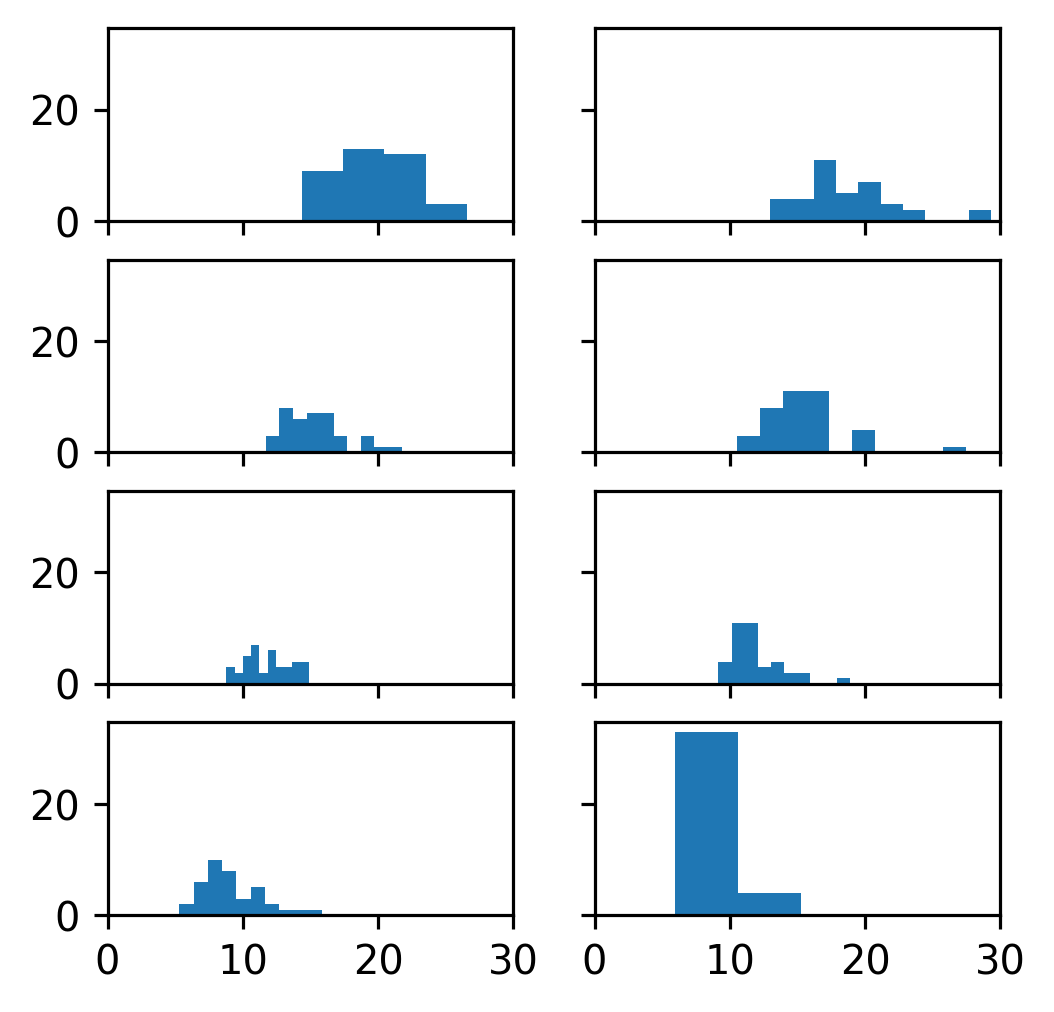

In [50]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['a'].values
        ax.hist(q)
        ax.set_xlim([0,30])

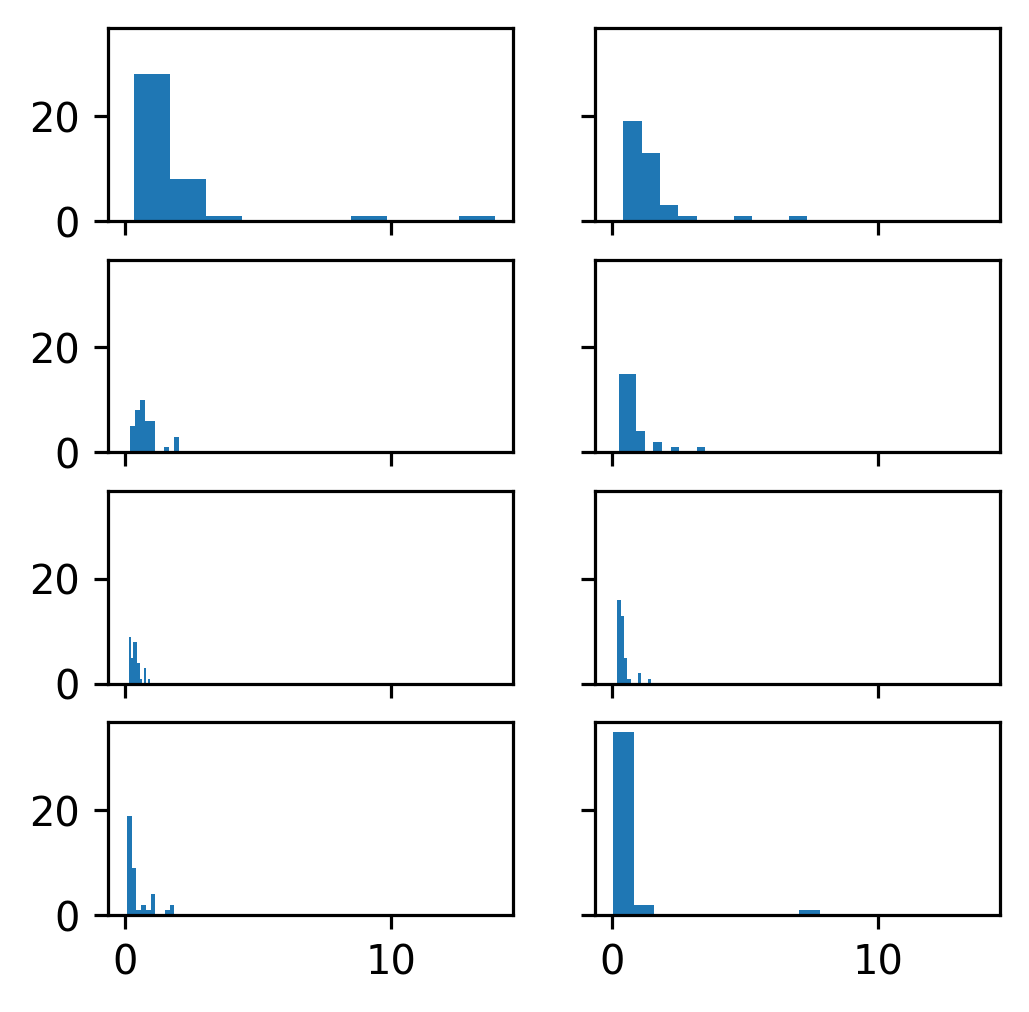

In [51]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['b'].values
        ax.hist(q)
        #ax.set_xlim([0,2])

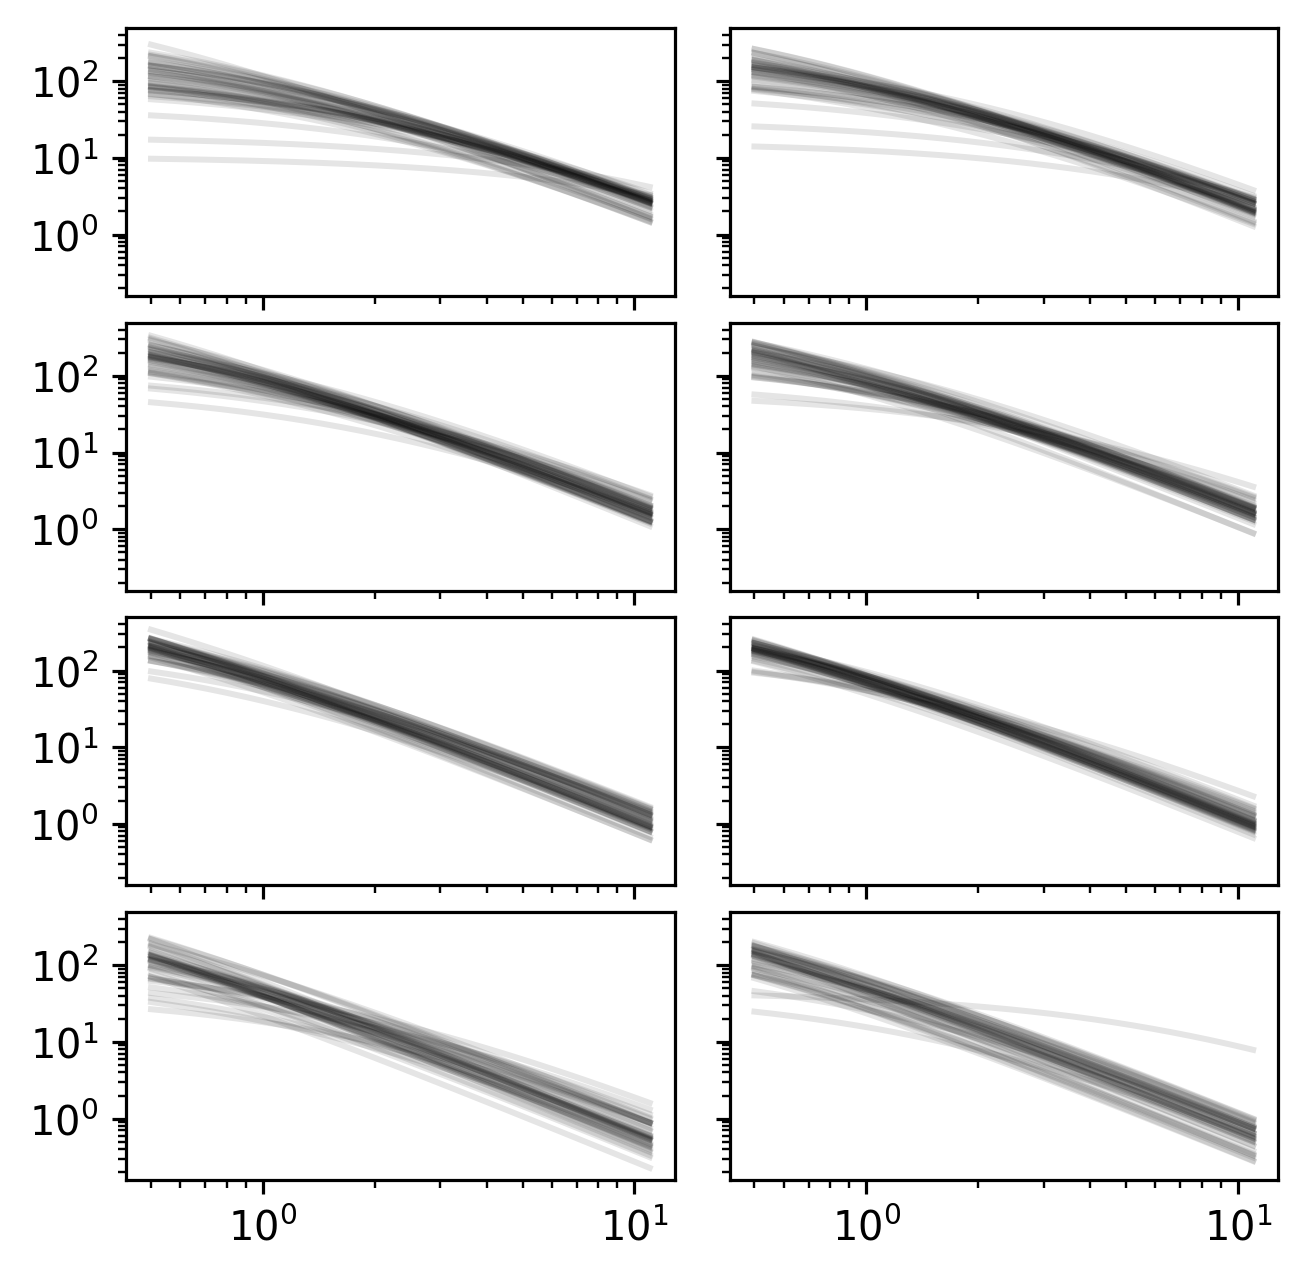

In [52]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.1,0.1)
eccrng = np.linspace(0.5, 11, 500)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        for (a,b) in zip(df2['a'].values, df2['b'].values):
            ax.loglog(eccrng, (a / (b + eccrng))**2, 'k-', alpha=0.1)

In [92]:
HH91_params[(HH91_params['label']==4) & (HH91_params['h']=='rh')]

,sid,h,label,a,b,loss
7,sub-wlsubj070,rh,4,11.100202,0.592944,1422.722442
15,sub-wlsubj114,rh,4,9.963533,0.248983,977.535433
23,sub-wlsubj121,rh,4,8.560254,0.367349,798.154255
31,sub-wlsubj135,rh,4,9.533288,1.413231,282.894445
39,sub-wlsubj119,rh,4,10.176864,0.290716,1041.989792
47,sub-wlsubj127,rh,4,10.562853,0.246196,1059.031074
55,sub-wlsubj136,rh,4,52.803952,7.804716,355.341577
63,sub-wlsubj137,rh,4,9.419775,0.177554,1082.376663
71,sub-wlsubj143,rh,4,8.354257,0.220060,158.309100
79,sub-wlsubj144,rh,4,8.097862,0.441108,497.715038


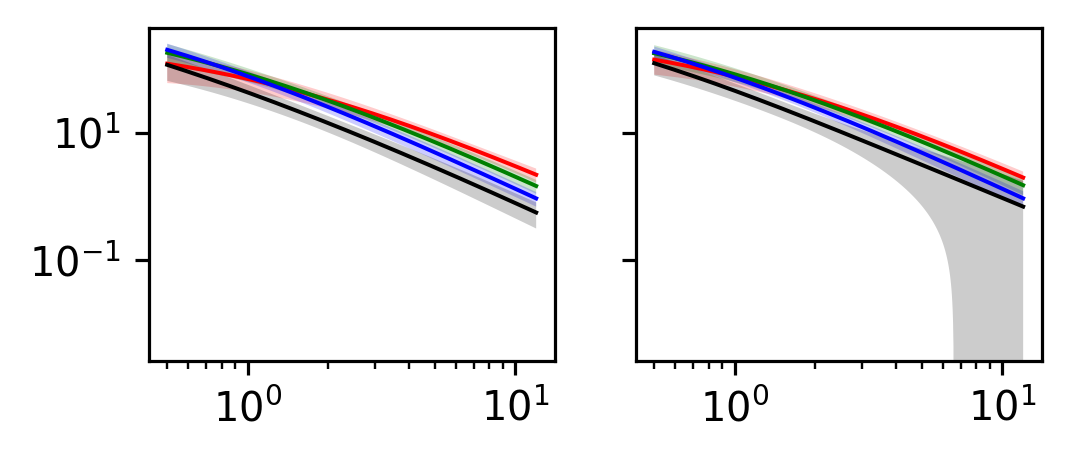

In [53]:
df = HH91_params
(fig,axs) = plt.subplots(1,2, figsize=(4,1.5), dpi=288, sharex=True, sharey=True)
eccrng = np.linspace(0.5, 12, 500)
for (lbl,clr) in zip([1,2,3,4], ['r','g','b','k']):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axs):
        df2 = df1[df1['h'] == h]
        a = df2['a'].values
        b = df2['b'].values
        m = (a[:,None] / (b[:,None] + eccrng[None,:]))**2
        mu = np.mean(m, axis=0)
        sd = np.std(m, axis=0)
        ax.fill_between(eccrng, mu - sd, mu + sd, edgecolor=None, facecolor=clr, alpha=0.2, zorder=-1)
        ax.loglog(eccrng, mu, clr+'-', lw=1)

## rerun analysis using the new fitting method

In [90]:
mean_cd_polar

,ID,Eccen_X,Eccen_Y,CrowdingDistance
0,sub-wlsubj001,-10.0,0.0,3.757971
1,sub-wlsubj001,-5.0,0.0,1.905962
2,sub-wlsubj001,-2.5,0.0,0.777402
3,sub-wlsubj001,0.0,-10.0,4.115811
4,sub-wlsubj001,0.0,-5.0,1.917689
...,...,...,...,...
235,sub-wlsubj158,0.0,5.0,1.284848
236,sub-wlsubj158,0.0,10.0,3.560097
237,sub-wlsubj158,2.5,0.0,0.329442
238,sub-wlsubj158,5.0,0.0,0.828792


In [100]:
# only look at horizontal meridian
# h is assigned 'lh' for x values larger than 0 and 'rh' otherwise
tmp = mean_cd_polar[mean_cd_polar['Eccen_Y']==0]
x = tmp['Eccen_X'].values
tmp['eccen'] = np.abs(x)
tmp['h'] = np.where(x > 0, 'lh', 'rh')
tmp.head(10)

/tmp/ipykernel_12758/2575108543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['eccen'] = np.abs(x)
/tmp/ipykernel_12758/2575108543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['h'] = np.where(x > 0, 'lh', 'rh')


,ID,Eccen_X,Eccen_Y,CrowdingDistance,eccen,h
0,sub-wlsubj001,-10.0,0.0,3.757971,10.0,rh
1,sub-wlsubj001,-5.0,0.0,1.905962,5.0,rh
2,sub-wlsubj001,-2.5,0.0,0.777402,2.5,rh
9,sub-wlsubj001,2.5,0.0,0.621637,2.5,lh
10,sub-wlsubj001,5.0,0.0,0.999534,5.0,lh
11,sub-wlsubj001,10.0,0.0,3.002173,10.0,lh
12,sub-wlsubj002,-10.0,0.0,7.190566,10.0,rh
13,sub-wlsubj002,-5.0,0.0,2.830694,5.0,rh
14,sub-wlsubj002,-2.5,0.0,1.723970,2.5,rh
21,sub-wlsubj002,2.5,0.0,0.704957,2.5,lh


In [101]:
tmp = tmp.drop(columns=['Eccen_X','Eccen_Y'])
tmp.rename(columns={'ID': 'sid'}, inplace=True)

In [102]:
df = HH91_params.copy()

df = df.merge(
    pd.DataFrame(dict(eccen=[2.5, 5.0, 10.0])),
    how='cross')

a = df['a']
b = df['b']
ecc = df['eccen']
df['cmag_fit'] = (a / (ecc + b))**2
# make it 1d visual magnification
df['1d_vmag_fit'] = np.sqrt(1/ (a / (ecc + b))**2)

In [103]:
# add crowding distance to df by merging it with tmp
df = df.merge(tmp, on=['sid', 'eccen','h'])

In [104]:
# 15 subs, 2 hemisphere * 3 ecc * 4 visual area
df

,sid,h,label,a,b,loss,eccen,cmag_fit,1d_vmag_fit,CrowdingDistance
0,sub-wlsubj070,lh,1,20.163431,1.104256,1457.656711,2.5,31.296625,0.178752,0.478005
1,sub-wlsubj070,lh,1,20.163431,1.104256,1457.656711,5.0,10.910969,0.302739,0.750864
2,sub-wlsubj070,lh,1,20.163431,1.104256,1457.656711,10.0,3.297235,0.550713,1.774424
3,sub-wlsubj070,lh,2,19.571239,1.482536,1274.891919,2.5,24.150003,0.203489,0.478005
4,sub-wlsubj070,lh,2,19.571239,1.482536,1274.891919,5.0,9.114792,0.331228,0.750864
...,...,...,...,...,...,...,...,...,...,...
355,sub-wlsubj158,rh,3,11.499979,0.346567,1236.602448,5.0,4.626409,0.464920,1.305139
356,sub-wlsubj158,rh,3,11.499979,0.346567,1236.602448,10.0,1.235383,0.899703,3.091969
357,sub-wlsubj158,rh,4,7.376804,0.109009,949.727986,2.5,7.994388,0.353677,0.354498
358,sub-wlsubj158,rh,4,7.376804,0.109009,949.727986,5.0,2.084794,0.692578,1.305139


In [105]:
tmp[tmp['sid']=='sub-wlsubj070']

,sid,CrowdingDistance,eccen,h
60,sub-wlsubj070,2.998793,10.0,rh
61,sub-wlsubj070,0.809616,5.0,rh
62,sub-wlsubj070,0.603452,2.5,rh
69,sub-wlsubj070,0.478005,2.5,lh
70,sub-wlsubj070,0.750864,5.0,lh
71,sub-wlsubj070,1.774424,10.0,lh


In [106]:
res = {1:[],2:[],3:[],4:[]}
for subject, subject_data in df.groupby(['sid']):
    for h in ['lh','rh']:
        ssdf = subject_data[subject_data['h'] == h]
        for lbl in [1,2,3,4]:
            sssdf = ssdf[ssdf['label'] == lbl]
            x = sssdf['1d_vmag_fit'].values
            y = sssdf['CrowdingDistance'].values
            (rss,coef) = cc.regression.fit_and_evaluate(x, y)
            res[lbl].append(rss)

In [107]:
grouped = df.groupby('sid') 
subject_results = {}

for subject, subject_data in grouped:
    if (subject_data['b']>5).any():
        continue
    subject_results[subject] = {}
    for h in ['lh', 'rh']:
        hemisphere_data = subject_data[subject_data['h'] == h]
        
        y1 = hemisphere_data[hemisphere_data['label'] == 1]['1d_vmag_fit'].values
        y2 = hemisphere_data[hemisphere_data['label'] == 2]['1d_vmag_fit'].values
        y3 = hemisphere_data[hemisphere_data['label'] == 3]['1d_vmag_fit'].values
        y4 = hemisphere_data[hemisphere_data['label'] == 4]['1d_vmag_fit'].values
        # since cd are the same for label 1,2,3,4
        y5 = hemisphere_data[hemisphere_data['label'] == 1]['CrowdingDistance'].values
        
        rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
        rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
        rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
        rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)
        
        rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
        best_fit_index = np.argmin(rss_values)
        best_fit = ['label_1', 'label_2', 'label_3', 'label_4'][best_fit_index]
        
        subject_results[subject][h] = {
            'rss_label_1': rss_y1, 'coef_label_1': coef_y1,
            'rss_label_2': rss_y2, 'coef_label_2': coef_y2,
            'rss_label_3': rss_y3, 'coef_label_3': coef_y3,
            'rss_label_4': rss_y4, 'coef_label_4': coef_y4,
            'best_fit': best_fit
        }

for subject, hemispheres in subject_results.items():
    print(f"Results for {subject}:")
    for h, results in hemispheres.items():
        print(f"  Hemisphere: {h}")
        print(f"    RSS for label 1: {results['rss_label_1']}, Coefficient: {results['coef_label_1']}")
        print(f"    RSS for label 2: {results['rss_label_2']}, Coefficient: {results['coef_label_2']}")
        print(f"    RSS for label 3: {results['rss_label_3']}, Coefficient: {results['coef_label_3']}")
        print(f"    RSS for label 4: {results['rss_label_4']}, Coefficient: {results['coef_label_4']}")
        print(f"    The best fit is: {results['best_fit']}\n")


Results for sub-wlsubj070:
  Hemisphere: lh
    RSS for label 1: 0.04290455908994073, Coefficient: 3.0217742525609532
    RSS for label 2: 0.05693085127765792, Coefficient: 2.800163985190904
    RSS for label 3: 0.022902785754280595, Coefficient: 2.154855027640123
    RSS for label 4: 0.018397655233728542, Coefficient: 0.9020012251839853
    The best fit is: label_4

  Hemisphere: rh
    RSS for label 1: 0.7400613823145867, Coefficient: 4.356990618403408
    RSS for label 2: 0.6940341200915818, Coefficient: 4.426905146572996
    RSS for label 3: 0.46988953693387187, Coefficient: 3.34399486993039
    RSS for label 4: 0.49812001152456753, Coefficient: 2.7675213603772533
    The best fit is: label_3

Results for sub-wlsubj114:
  Hemisphere: lh
    RSS for label 1: 0.10317768630199801, Coefficient: 6.184471820997239
    RSS for label 2: 0.07664693365562032, Coefficient: 4.821533794725734
    RSS for label 3: 0.08785259591920047, Coefficient: 4.452404927497697
    RSS for label 4: 0.0458579

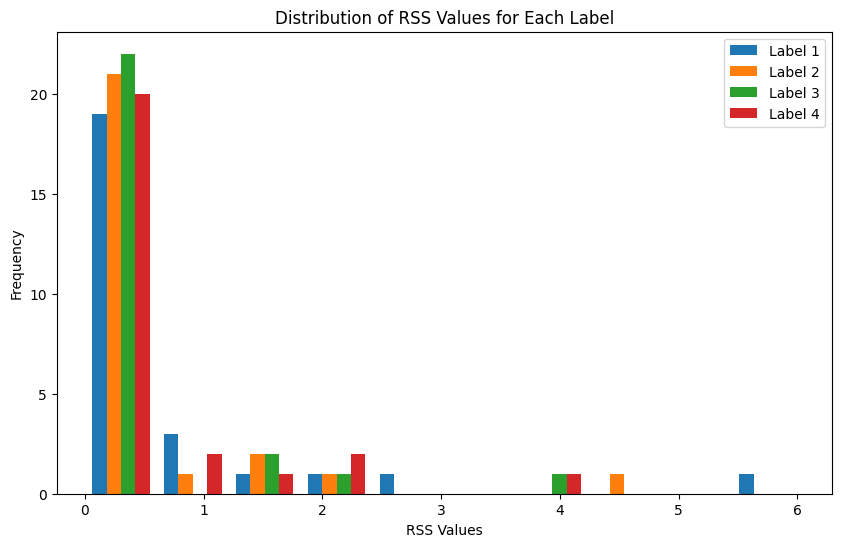

In [108]:
rss_keys = ['rss_label_1', 'rss_label_2', 'rss_label_3', 'rss_label_4']

data = [[
    hemispheres[h][key]  
    for subject, hemispheres in subject_results.items()
    for h in ['lh', 'rh'] 
] for key in rss_keys]

plt.figure(figsize=(10, 6))
plt.hist(data, label=['Label 1', 'Label 2', 'Label 3', 'Label 4'])
plt.xlabel('RSS Values')
plt.ylabel('Frequency')
plt.title('Distribution of RSS Values for Each Label')
plt.legend()
plt.show()

In [109]:
rss_label_1_values = []
rss_label_2_values = []
rss_label_3_values = []
rss_label_4_values = []

for subject, hemispheres in subject_results.items():
    for h in ['lh', 'rh']:
        rss_label_1_values.append(hemispheres[h]['rss_label_1'])
        rss_label_2_values.append(hemispheres[h]['rss_label_2'])
        rss_label_3_values.append(hemispheres[h]['rss_label_3'])
        rss_label_4_values.append(hemispheres[h]['rss_label_4'])

mean_rss_label_1 = np.mean(rss_label_1_values)
mean_rss_label_2 = np.mean(rss_label_2_values)
mean_rss_label_3 = np.mean(rss_label_3_values)
mean_rss_label_4 = np.mean(rss_label_4_values)

std_rss_label_1 = np.std(rss_label_1_values)
std_rss_label_2 = np.std(rss_label_2_values)
std_rss_label_3 = np.std(rss_label_3_values)
std_rss_label_4 = np.std(rss_label_4_values)

print(f"Mean RSS for Label 1: {mean_rss_label_1:.4f}, Standard Deviation: {std_rss_label_1:.4f}")
print(f"Mean RSS for Label 2: {mean_rss_label_2:.4f}, Standard Deviation: {std_rss_label_2:.4f}")
print(f"Mean RSS for Label 3: {mean_rss_label_3:.4f}, Standard Deviation: {std_rss_label_3:.4f}")
print(f"Mean RSS for Label 4: {mean_rss_label_4:.4f}, Standard Deviation: {std_rss_label_4:.4f}")


Mean RSS for Label 1: 0.6565, Standard Deviation: 1.2507
Mean RSS for Label 2: 0.5146, Standard Deviation: 0.9728
Mean RSS for Label 3: 0.4643, Standard Deviation: 0.8820
Mean RSS for Label 4: 0.5072, Standard Deviation: 0.9092


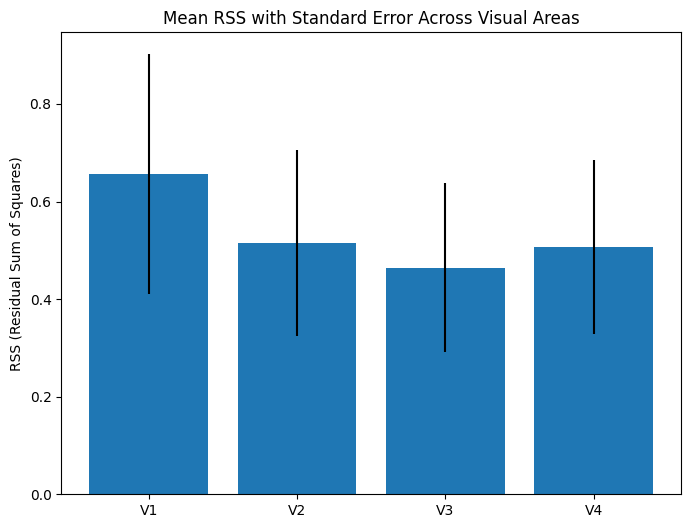

In [110]:
mean_rss = [mean_rss_label_1, mean_rss_label_2, mean_rss_label_3, mean_rss_label_4]
std_rss = [std_rss_label_1, std_rss_label_2, std_rss_label_3, std_rss_label_4]

labels = ['V1', 'V2', 'V3', 'V4']

# standard error of the mean (SEM)
n_subjects = len(subject_results) * 2  # for both hemispheres
sem_rss = np.array(std_rss) / np.sqrt(n_subjects)

plt.figure(figsize=(8, 6))
plt.bar(labels, mean_rss, yerr=sem_rss)

plt.ylabel('RSS (Residual Sum of Squares)')
plt.title('Mean RSS with Standard Error Across Visual Areas')

plt.show()

In [111]:
{k:np.mean(v) for (k,v) in res.items()}

{1: 0.6767611496397118,
 2: 0.4797794822036391,
 3: 0.4265531409780296,
 4: 0.4873089970389591}

In [112]:
{k:np.std(v) for (k,v) in res.items()}

{1: 1.203873744602344,
 2: 0.9139439796151722,
 3: 0.8292518164647509,
 4: 0.8644237829583785}

(array([[21.,  4.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  1.],
        [25.,  1.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.],
        [26.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [23.,  3.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  0.]]),
 array([7.65700382e-05, 6.05545227e-01, 1.21101388e+00, 1.81648254e+00,
        2.42195120e+00, 3.02741985e+00, 3.63288851e+00, 4.23835717e+00,
        4.84382583e+00, 5.44929448e+00, 6.05476314e+00]),
 <a list of 4 BarContainer objects>)

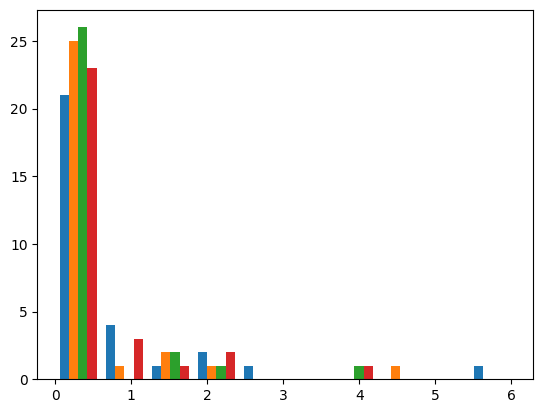

In [113]:
plt.hist(list(res.values()))

**Below this point, I'm not sure that things are done correctly! Please check the code dealing with the crowding dataframe to make sure it is reasonable!**

In [89]:
crowd_df = pd.read_csv('/data/crowding/crowding_data_withID.csv')
crowd_df

,ID,FlankinDirection,Eccen_X,Eccen_Y,CrowdingDistance,Session,RadialEccentricity
0,sub-wlsubj153,radial,5.0,0.0,3.701109,1,5.0
1,sub-wlsubj153,radial,-5.0,-0.0,2.805407,1,5.0
2,sub-wlsubj153,radial,0.0,5.0,3.498309,1,5.0
3,sub-wlsubj153,radial,-0.0,-5.0,2.551906,1,5.0
4,sub-wlsubj153,radial,10.0,0.0,7.250118,1,10.0
...,...,...,...,...,...,...,...
475,sub-wlsubj005,radial,-0.0,-5.0,1.487204,2,5.0
476,sub-wlsubj005,radial,2.5,0.0,0.439401,2,2.5
477,sub-wlsubj005,radial,-2.5,-0.0,0.659102,2,2.5
478,sub-wlsubj005,radial,0.0,2.5,0.760502,2,2.5


In [253]:
df = HH91_params.copy()

df = df.merge(
    pd.DataFrame(dict(eccen=[2.5, 5.0, 10.0])),
    how='cross')

a = df['a']
b = df['b']
ecc = df['eccen']
df['cmag'] = (a / (ecc + b))**2
df['vmag'] = (a / (ecc + b))**-2

crowd_df = pd.read_csv('/data/crowding/crowding_data_withID.csv')
crowd_df.rename(
    columns=dict(ID='sid', Eccen_X='x', Eccen_Y='y', RadialEccentricity='eccen', CrowdingDistance='cd'),
    inplace=True)
crowd_df = crowd_df[crowd_df['y'] == 0]
crowd_df = crowd_df.groupby(['sid','x','y'])['cd'].apply(gmean).reset_index()
x = crowd_df['x'].values
crowd_df['h'] = np.array(['lh','rh'])[(x != 0).astype(int)]
crowd_df['eccen'] = np.abs(x)
crowd_df = crowd_df.drop(columns=['x','y'])
crowd_df = crowd_df[['sid', 'eccen', 'cd']]
crowd_df = crowd_df.groupby(['sid', 'eccen'])['cd'].apply(gmean).reset_index()

df = df.merge(crowd_df, on=['sid', 'eccen'])

In [256]:
ssdf

,sid,h,label,a,b,loss,eccen,cmag,vmag,cd
0,sub-wlsubj119,lh,1,20.628879,1.601142,1022.214056,2.5,25.301229,0.039524,0.384077
1,sub-wlsubj119,lh,1,20.628879,1.601142,1022.214056,5.0,9.765918,0.102397,0.999763
2,sub-wlsubj119,lh,1,20.628879,1.601142,1022.214056,10.0,3.161912,0.316264,1.731569
12,sub-wlsubj119,rh,1,24.220382,1.652452,5475.886536,2.5,34.021438,0.029393,0.384077
13,sub-wlsubj119,rh,1,24.220382,1.652452,5475.886536,5.0,13.255571,0.075440,0.999763
14,sub-wlsubj119,rh,1,24.220382,1.652452,5475.886536,10.0,4.320433,0.231458,1.731569


In [260]:
res = {1:[],2:[],3:[],4:[]}
for (sidtup,sdf) in df.groupby(['sid']):
    for h in ['lh','rh']:
        ssdf = sdf[sdf['h'] == h]
        for lbl in [1,2,3,4]:
            sssdf = ssdf[ssdf['label'] == lbl]
            x = np.sqrt(sssdf['vmag'].values)
            y = sssdf['cd'].values
            (rss,coef) = cc.regression.fit_and_evaluate(x, y)
            res[lbl].append(rss)

In [262]:
{k:np.mean(v) for (k,v) in res.items()}

{1: np.float64(0.5041128930443209),
 2: np.float64(0.3640139302827354),
 3: np.float64(0.33850525984539964),
 4: np.float64(0.32755666214741547)}

(array([[15.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [17.,  2.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
        [19.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
        [18.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.]]),
 array([3.03195890e-03, 3.45829366e-01, 6.88626774e-01, 1.03142418e+00,
        1.37422159e+00, 1.71701900e+00, 2.05981640e+00, 2.40261381e+00,
        2.74541122e+00, 3.08820862e+00, 3.43100603e+00]),
 <a list of 4 BarContainer objects>)

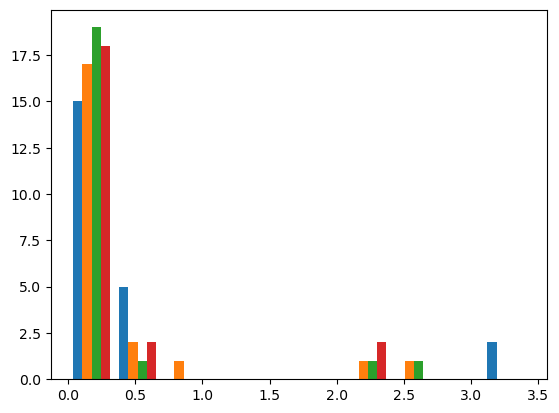

In [263]:
plt.hist(list(res.values()))